# Tutorial: applying strainFlye to the "SheepGut" dataset

This tutorial will walk you through the various commands strainFlye offers.

## 0. Following this tutorial

Depending on your dataset and goals, you could either walk through the entirety of this document or skip around a bit. You can "jump to" many steps of the pipeline without trouble; for example, if you already have a BCF file of single-nucleotide mutations, you may prefer to skip all of the naïve mutation calling / FDR estimation steps and jump to the phasing analyses.

Note that many of the steps of this pipeline can take a while to run for large datasets like SheepGut. (In my experience: for the full SheepGut dataset on our cluster, "a while" usually means around 24 hours.) Smaller datasets and/or faster machines should of course decrease this duration. Section 5 of this tutorial ("**Optional: Filter the FASTA file in order to focus on certain contigs**") discusses how you can subset your dataset, after the `align` step, to certain contigs of interest—this can also speed things up.

([Obligatory xkcd link.](https://xkcd.com/1343/))

## 1. The two main strainFlye inputs

The strainFlye pipeline takes as input two main types of data:

1. A __set of reads__ (in FASTA / FASTQ format).

2. A __set of contigs__ (in FASTA format) assembled from these reads.

This assumes that you're starting the pipeline at the beginning (with `align`). Later pipeline steps will require other inputs that can be produced by intermediate pipeline steps.

### 1.1. Details about these types of inputs

**Regarding reads:** We designed strainFlye in the context of PacBio Circular Consensus Sequencing (CCS) "HiFi" reads ([Wenger & Peluso _et al._, 2019](https://www.nature.com/articles/s41587-019-0217-9)). However, in theory it should still work with other reasonably long and accurate reads.

**Regarding contigs:** We don't impose any restriction on the assembler you use to construct these. We have tested strainFlye on [metaFlye](https://github.com/fenderglass/Flye) ([Kolmogorov _et al._, 2020](https://www.nature.com/articles/s41592-020-00971-x)) and [hifiasm-meta](https://github.com/xfengnefx/hifiasm-meta) ([Feng _et al._, 2022](https://www.nature.com/articles/s41592-022-01478-3)) output, but it should in theory work with the outputs of other HiFi assemblers.

### 1.2. The SheepGut dataset

We'll be applying strainFlye to the SheepGut dataset that is shown in our paper. (This dataset has also been described in ([Kolmogorov _et al._, 2020](https://www.nature.com/articles/s41592-020-00971-x) and [Bickhart & Kolmogorov _et al._, 2022](https://www.nature.com/articles/s41587-021-01130-z).) Please see the strainFlye paper's "Data access" section for details about acquiring reads and contigs for the SheepGut dataset.

Note that the "contigs" we use for the SheepGut datatset really correspond to edge sequences in the `assembly_graph.gfa` file produced by metaFlye. These edge sequences may be slightly different from the file of contigs / scaffolds in the `assembly.fasta` file produced by metaFlye: see [Flye's manual](https://github.com/fenderglass/Flye/blob/flye/docs/USAGE.md#output) for more information. (You could use either type of sequence with strainFlye, although I personally recommend using edges: it's useful to have context about where exactly in the assembly graph a sequence is, and things like gaps in scaffolds [represented by `N`s] will cause strainFlye to complain.)

## 2. Introduction

Let's take care of a few things before the tutorial starts.

### 2.1. Installing strainFlye

Before following along with this tutorial, we assume that you have already installed strainFlye (and have activated the corresponding conda environment). Please see [strainFlye's README](https://github.com/fedarko/strainFlye) for installation instructions.

### 2.2. What commands are available through strainFlye?

In [1]:
!strainFlye

Usage: strainFlye [OPTIONS] COMMAND [ARGS]...

  Pipeline for the analysis of rare mutations in metagenomes.

  Please consult https://github.com/fedarko/strainFlye if you have any
  questions, comments, etc. about strainFlye. Thank you for using this tool!

Options:
  -v, --version  Show the version and exit.
  -h, --help     Show this message and exit.

Commands:
  align   Align reads to contigs, and filter the resulting alignment.
  call    [+] Call mutations in contigs naïvely & compute diversity indices.
  fdr     [+] Estimate and fix FDRs for contigs' naïve mutation calls.
  spot    [+] Identify putative mutational hotspots or coldspots.
  smooth  [+] Create and assemble smoothed and virtual reads.
  link    [+] Create link graphs showing co-occurring alleles.
  matrix  [+] Create codon and amino acid mutation matrices.
  dynam   [+] Compute simple information about growth dynamics.
  utils   [+] Miscellaneous utility commands provided with strainFlye.


### 2.3. Importing and configuring some utilities

You shouldn't need to do much (if any) programming to use strainFlye's commands; that said, we will be using Python to help with a few small tasks throughout this tutorial, and you will probably need to do some programming to plot the results we produce. (This philosophy was inspired partially by [Schloss 2020](https://journals.asm.org/doi/full/10.1128/AEM.02343-19).) We'll import some useful Python packages here to reduce clutter later on in this notebook.

(If you prefer, you could of course use another language instead of Python.)

In [118]:
import time
import skbio
import pandas as pd
import matplotlib
from matplotlib import pyplot
# Make the plots look nice -- this is the style we use in the paper
pyplot.style.use("ggplot")

## 3. Convert the assembly graph GFA file to a FASTA file of contigs

**You can skip this step if:** you already have a FASTA file describing contigs in your assembly graph.

Our assembly graph (the GFA file) contains the sequences of the contigs that we will use in many downstream analyses, but we'll need to have a FASTA file that just describes these contigs' sequences (independent of the assembly graph topology).

There are some [bash one-liners](https://www.biostars.org/p/169516/#169530) you can use to convert a GFA 1 file to a FASTA file, but strainFlye also provides a utility command (`strainFlye utils gfa-to-fasta`) to do this for you. We'll use this here. (Our solution may be a bit slower than a bash one-liner, but it performs some useful sanity checking on the GFA file.)

In [3]:
!strainFlye utils gfa-to-fasta \
    --graph /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa \
    --output-fasta /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta

Using strainFlye version "0.1.0-dev".
--------
utils gfa-to-fasta @ 0.00s: Starting...
Input GFA file: /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa
Output FASTA file: /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta
--------
utils gfa-to-fasta @ 18.97s: Done.
Output FASTA file contains 78,793 sequences.


## 4. Align reads to contigs; filter the resulting alignment

**You can skip this step if:** you already have a BAM file representing an alignment of reads to contigs, and this BAM file does not contain secondary alignments / partially-mapped reads / overlapping supplementary alignments (these all may cause problems in downstream analyses).

We'll need to align reads back to these contigs. The resulting alignment, and/or the mutations that we call from it, will be used in pretty much all downstream steps—so it's important to make sure that it is of good quality!

The `strainFlye align` command uses minimap2 to perform alignment, and then does some extra filtering on the resulting alignment.

Note that this command, in particular, may take a while to run. Sequence alignment is computationally expensive! On our cluster, `strainFlye align` ran on the full SheepGut dataset in 62,941.21 seconds (aka about 17.5 hours).

In [4]:
!strainFlye align

Usage: strainFlye align [OPTIONS] READS...

  Align reads to contigs, and filter the resulting alignment.

  Files of reads should be in the FASTA or FASTQ formats; GZIP'd files are
  allowed.

  This command involves multiple steps, including:

    1) Align reads to contigs (using minimap2) to generate a SAM file
    2) Convert this SAM file to a sorted and indexed BAM file
    3) Filter overlapping supplementary alignments (OSAs) from this BAM file
    4) Filter partially-mapped reads from this BAM file

  Note that we only sort the alignment file once, although we do re-index it
  after the two filtering steps. This decision is motivated by
  https://www.biostars.org/p/131333/#131335.

Options:
  -c, --contigs PATH              FASTA file of contigs to which reads will be
                                  aligned.  [required]
  -g, --graph PATH                GFA 1-formatted file describing an assembly
                                  graph of the contigs. This is used in the
     

In [4]:
!strainFlye align \
    # We can use the FASTA file we just generated above.
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta \
    --graph /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/alignment \
    # Reads file(s) are specified here, after all of the other parameters:
    /Poppy/mkolmogo/sheep_meta/data/sheep_poop_CCS_dedup.fastq.gz \
    /Poppy/mkolmogo/sheep_meta/data/ccs_sequel_II/*.fasta.gz

This generates a BAM file (`final.bam`) and BAM index file (`final.bam.bai`) in the specified output directory.

We can use this BAM file for many analyses downstream—the first of these will be mutation calling.

## 5. Optional: Filter the FASTA file in order to focus on certain contigs

We just aligned our dataset's reads against *all* contigs in the assembly graph. This is standard practice (see, e.g., [this tutorial](https://astrobiomike.github.io/genomics/metagen_anvio#mapping-our-reads-to-the-assembly-they-built)); aligning reads against all contigs probably yields a more accurate alignment than just aligning reads against a subset of these contigs (although proving if this is "best practice" or not is a challenging question, and one that I will sidestep right now).

However, now that we have this alignment, we don't necessarily need to perform mutation calling, phasing, etc. on all contigs (although, if you want to, we could!). To speed up the rest of this tutorial, **we will focus solely on the "long" contigs in this dataset**: here, we will define a contig as "long" if its length is at least 1 Mbp (aka 1,000,000 bp). In theory, these long contigs represent putative metagenome-assembled genomes (MAGs).

Of course, if you prefer, you could apply more sophisticated criteria to pick which contigs to focus on—maybe you'd like to also focus on contigs with high coverages, or maybe on contigs with good [CheckM](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4484387/) completeness or contamination values. Or maybe you'd like to keep considering all contigs in the full dataset! Your decision should depend on your goals, and your dataset.

In any case, how do we "focus on" certain contigs? **We can filter our FASTA file to a subset of contigs present in the full dataset**, and use this filtered FASTA file for all downstream analyses. As an example of this, we will use Python (in particular, the [scikit-bio](http://scikit-bio.org/) library) to filter our FASTA file to all long contigs.

In [15]:
# Produce a filtered FASTA file containing only contigs >= 1 Mbp long
# (This uses scikit-bio; see http://scikit-bio.org/ for more details.)

input_contigs_fp = "/Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta"
output_contigs_fp = "/Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta"
len_threshold = 1000000

t0 = time.time()
num_long_contigs = 0
with open(output_contigs_fp, "w") as of:
    for contig in skbio.io.read(input_contigs_fp, format="fasta", constructor=skbio.DNA):
        if len(contig) >= len_threshold:
            skbio.io.write(contig, format="fasta", into=of)
            num_long_contigs += 1
t1 = time.time()

print(f"Found {num_long_contigs:,} contigs with lengths \u2265 {len_threshold:,} bp. Took {t1 - t0:,.2f} sec.")

Found 468 contigs with lengths ≥ 1,000,000 bp. Took 12.30 sec.


The remainder of this tutorial will focus on these 468 long contigs.

In any case, now we can get on to some more interesting stuff!

## 6. Perform naïve mutation calling, then estimate and fix mutation calls' FDRs

**You can skip this step if:** You already have a BCF file describing single-nucleotide, non-multi-allelic mutations in your contigs.

The analyses downstream of this step (hotspot/coldspot identification, phasing) take as input a set of identified single-nucleotide mutations (or, if you prefer to use different terminology, "called variants", "called SNVs", ...) in which we have some confidence. How does strainFlye identify these mutations?

There are a few steps (as our paper describes). First, we will **naïvely call mutations** using a simple threshold-based method (referred to as "NaiveFreq" in the paper). We can then **estimate the false-discovery rates (FDRs) of the mutations called for each contig** using the target-decoy approach. If desired, we can then adjust the called mutations to **fix the estimated FDRs of these mutation calls** below a specified threshold.

### 6.1. $p$-mutations and $r$-mutations?

So, our first step will be performing this simple threshold-based calling. What do we mean by "threshold" here?

strainFlye supports calling two basic types of mutations: $p$-mutations and $r$-mutations. The docs explain the difference between these two types best:

In [5]:
!strainFlye call

Usage: strainFlye call [OPTIONS] COMMAND [ARGS]...

  [+] Call mutations in contigs naïvely & compute diversity indices.

  Consider a position "pos" in a contig. Using the alignment, we can count how
  many reads have a (mis)match operation to "pos" with one of the four
  nucleotides (A, C, G, T; we ignore degenerate nucleotides in reads). We
  represent these four nucleotides' counts at pos as follows:

      N1 = # reads of the most-common aligned nucleotide at pos,
      N2 = # reads of the second-most-common aligned nucleotide at pos,
      N3 = # reads of the third-most-common aligned nucleotide at pos,
      N4 = # reads of the fourth-most-common aligned nucleotide at pos.

  (We break ties arbitrarily.)

  strainFlye supports two types of naïve mutation calling based on these
  counts: p-mutations and r-mutations. These are described below.

  p-mutations (naïve percentage-based mutation calling)
  -----------------------------------------------------

  This takes as input som

### 6.2. Understanding these (sub)commands

First off, note that `strainFlye call` doesn't do anything besides show help info if you run it by itself. This is because, unlike `strainFlye align`, `strainFlye call` has two subcommands: `p-mutation` and `r-mutation`. Which of these you use will depend on how you want to naïvely call mutations. You can invoke one of these subcommands by writing out the full chain of commands: for example, `strainFlye call p-mutation`.

#### 6.2.1. Input and output

Probably the most important parameter at this step is the *minimum threshold*. Both of these subcommands, `strainFlye call p-mutation` and `strainFlye call r-mutation`, take as input a minimum version of their corresponding threshold (either `--min-p` or `--min-r`).

These commands each output:

1. A __BCF (binary [variant call format](https://samtools.github.io/hts-specs/VCFv4.3.pdf)) file__ describing all mutations called naïvely across the contigs, based on the minimum $p$ or $r$ threshold set (`--min-p` or `--min-r`).

2. A __TSV ([tab separated values](https://en.wikipedia.org/wiki/Tab-separated_values)) file__ describing the contigs' computed diversity indices, for various values of $p$ or $r$ (configurable using the `--div-index-p-list` or `--div-index-r-list` parameters).
  - Long story short, diversity indices indicate how many of a contig's "sufficiently-covered" positions have called mutations: in general, higher diversity indices imply higher mutation rates.
  - If enough positions in a contig are not "sufficiently-covered," then we will not compute the diversity index for this contig. Please see the Supplemental Material "Diversity index details" in the strainFlye paper for details.

#### 6.2.2. Interpreting the output

The default minimum value of $p$ (or $r$) used in these commands is fairly low. As you might expect, using such a low threshold for calling a position as a mutation may yield many false positives: we will almost certainly identify many real mutations, but also many "false" mutations that happen to occur as the result of sequencing errors, alignment errors, etc. Viewed another way, the __[false discovery rate (FDR)](https://en.wikipedia.org/wiki/False_discovery_rate)__ (defined as the ratio of false positives to total true + false positives) of the mutation calls generated at this step will probably be high—although this depends on a variety of factors, including which contig(s) we are focusing on mutations in, what our goals are in the first place, etc.

##### FDR estimation and fixing

After we run this command, we can use strainFlye's FDR estimation and fixing functionality to attempt to address this problem. This process involves adjusting the "minimum" value of $p$ (or $r$) used for each contig to reduce the FDR as needed.

Depending on your dataset and your goals, you may or may not want to do this: as of writing, many of the analyses in the strainFlye paper don't perform FDR fixing on their input mutations, and instead just make use of "un-fixed" naïvely called $p$-mutations. (That being said, this is mostly a historical artifact of us implementing the FDR fixing code close to the end of the project.)

In general, if you are going to perform FDR estimation / fixing, we recommend only doing this for $p$-mutations (and not $r$-mutations); this is discussed in the strainFlye paper, in the Supplemental Material section named "Identifying mutations based solely on read counts."

### 6.3. Naïvely call $p$-mutations ($p = 0.15\%$) and compute diversity indices for various values of $p$

Now that we know what we're doing, we're ready to call mutations and compute diversity indices! We'll do $p$-mutation calling at a minimum $p$ of $0.15\%$, which matches what we used for Figure 2 in the paper. The default diversity index values of $p$ (ranging from $0.5\%$ to $50\%$) should be good for us.

Like alignment, this command will also take a while—we need to check each position in the alignment for each of the input contigs. If you'd like, you can use the `--verbose` flag to display some extra information while this command is running, to make the wait more tolerable (and assure you that it isn't frozen somewhere).

In [6]:
!strainFlye call p-mutation

Usage: strainFlye call p-mutation [OPTIONS]

  Call p-mutations and compute diversity indices.

  The primary parameter for this command is the lower bound of p, defined by
  --min-p. The BCF output will include "mutations" for all positions that pass
  this (likely very low) threshold; this BCF can be filtered using the
  utilities contained in the "strainFlye fdr" module.

Options:
  -c, --contigs PATH              FASTA file of contigs in which to naïvely
                                  call mutations. All contigs in this FASTA
                                  file should also be contained in the BAM
                                  file; it's ok if the BAM file contains
                                  contigs not in this FASTA file (we'll ignore
                                  them).  [required]
  -b, --bam PATH                  Sorted and indexed BAM file representing an
                                  alignment of reads to contigs.  [required]
  --min-p INTEGER RANGE   

In [ ]:
!strainFlye call p-mutation \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta \
    --bam /Poppy/mfedarko/sftests/tutorial-output/alignment/final.bam \
    --min-p 15 \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/call-p15

### 6.4. Estimating FDRs using the target-decoy approach

We now have both our initial mutation calls (which, as we've discussed, probably have a high FDR) and information about our contigs' diversity indices. We will use the __target-decoy approach__ to attempt to estimate and thus control the FDR of our mutation calls. This is done by the `strainFlye fdr estimate` and `strainFlye fdr fix` commands.

As discussed in our paper, we can select—out of one of our $C$ contigs—a __decoy contig__ (a.k.a. a decoy genome), and compute a mutation rate for it ($\text{rate}_{\text{decoy}}$). For each of the other $C - 1$ __target contigs__, we can estimate the FDR of identified mutations in this contig as $\dfrac{\text{rate}_{\text{decoy}}}{\text{rate}_{\text{target}}}$.

#### 6.4.1. Manually selecting a decoy contig

If you'd like, we could go through the diversity indices produced by `strainFlye call p-mutation` ourselves, in an attempt to select a reasonable-seeming decoy contig. **[This notebook](https://nbviewer.org/github/fedarko/strainFlye/blob/main/docs/AnalyzingDiversityIndices.ipynb)** demonstrates this sort of process.

#### 6.4.2. Letting `strainFlye fdr estimate` automatically select a decoy contig

The optional notebook discussed above shows that `edge_6104` is probably a good decoy contig, so we could if desired just pass it to `strainFlye fdr estimate` using that command's `-dc` or `--decoy-contig` option. However, to illustrate another option, we'll instead pass our diversity index TSV file to `strainFlye fdr estimate` and let it do the job of selecting a decoy contig. (Spoiler alert: it'll select `edge_6104` anyway.)

The Methods section of our paper provides details about how the automatic decoy contig selection algorithm works. If you'd prefer, you can also go through the exact source code for it, which is reasonably well-documented: see the `autoselect_decoy()` function in **[this file](https://github.com/fedarko/strainFlye/blob/main/strainflye/fdr_utils.py#L101)**.

In [7]:
!strainFlye fdr

Usage: strainFlye fdr [OPTIONS] COMMAND [ARGS]...

  [+] Estimate and fix FDRs for contigs' naïve mutation calls.

Options:
  -h, --help  Show this message and exit.

Commands:
  estimate  Estimate the FDRs of contigs' mutation calls.
  fix       Fix contigs' mutation calls' estimated FDRs to an upper limit.


In [8]:
!strainFlye fdr estimate

Usage: strainFlye fdr estimate [OPTIONS]

  Estimate the FDRs of contigs' mutation calls.

  We do this using the target-decoy approach (TDA). Given a set of C contigs,
  we select a "decoy contig" with relatively few called mutations. We then
  compute a mutation rate for this decoy contig, and use this mutation rate
  (along with the mutation rates of the other C - 1 "target" contigs) to
  estimate the FDRs of all of these target contigs' mutation calls.

  We can produce multiple FDR estimates for a single target contig's calls by
  varying the p or r threshold used (from the --min-p or --min-r threshold
  used to generate the input BCF file, up to the --high-p or --high-r
  threshold given here). Using this information (and information about the
  numbers of mutations called per megabase), we can plot an FDR curve for a
  given target contig's mutation calls.

  This command accepts an input BCF file of p- or r-mutations; however, in
  general we recommend using p-mutations (rather

In [7]:
!strainFlye fdr estimate \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta \
    --bam /Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/call-p15/naive-calls.bcf \
    --diversity-indices /Poppy/mfedarko/sftests/tutorial-output/call-p15/diversity-indices.tsv \
    --decoy-contexts Everything
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/p15-fdr-info

--------
strainFlye fdr estimate @ 0.00 sec: Starting...
Input contig file: /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta
Input BAM file: /Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/call-p15/naive-calls.bcf
Input diversity indices file: /Poppy/mfedarko/sftests/tutorial-output/call-p15/diversity-indices.tsv
Input manually-set decoy contig: None
Input decoy contig context-dependent position / mutation type(s): ('Full', 'CP2', 'Tv', 'Nonsyn', 'Nonsense', 'CP2Tv', 'CP2Nonsyn', 'CP2Nonsense', 'TvNonsyn', 'TvNonsense', 'CP2TvNonsense')
Input high p threshold (only used if the BCF describes p-mutations): 500
Input high r threshold (only used if the BCF describes r-mutations): 100
Input min length of a potential decoy contig (only used if diversity indices are specified): 1000000
Input min average coverage of a potential decoy contig (only used if diversity indices are spec

Let's check on the TSV files that got written to the output directory. We should see one file for every decoy context, indicating the FDR estimates for each target contig for this context; and one lone "number of mutations per Mb" file, indicating the number of mutations per megabase for each target contig.

In general, we can plot these as FDR curves by using the FDR estimates as x-axis values and the "number of mutations per Mb" values as y-axis values.

In [7]:
!ls /Poppy/mfedarko/sftests/tutorial-output/p15-fdr-info/

fdr-CP2Nonsense.tsv    fdr-CP2Tv.tsv	 fdr-TvNonsense.tsv
fdr-CP2Nonsyn.tsv      fdr-Full.tsv	 fdr-TvNonsyn.tsv
fdr-CP2.tsv	       fdr-Nonsense.tsv  fdr-Tv.tsv
fdr-CP2TvNonsense.tsv  fdr-Nonsyn.tsv	 num-mutations-per-mb.tsv


### 6.5. Plotting FDR curves

**[This notebook (in the analysis code repository)](https://nbviewer.org/github/fedarko/sheepgut/blob/main/sf-analyses/sheep/3-PlotFDRCurves.ipynb)** demonstrates how we can plot some or all of these FDR estimates for our target contigs. See the screenshot below for an example figure, showing most of the decoy contexts for eight target contigs in the SheepGut dataset. (I put a decent amount of work into making those plots look fancy for the paper, but you don't need to do all this work unless you want to!)

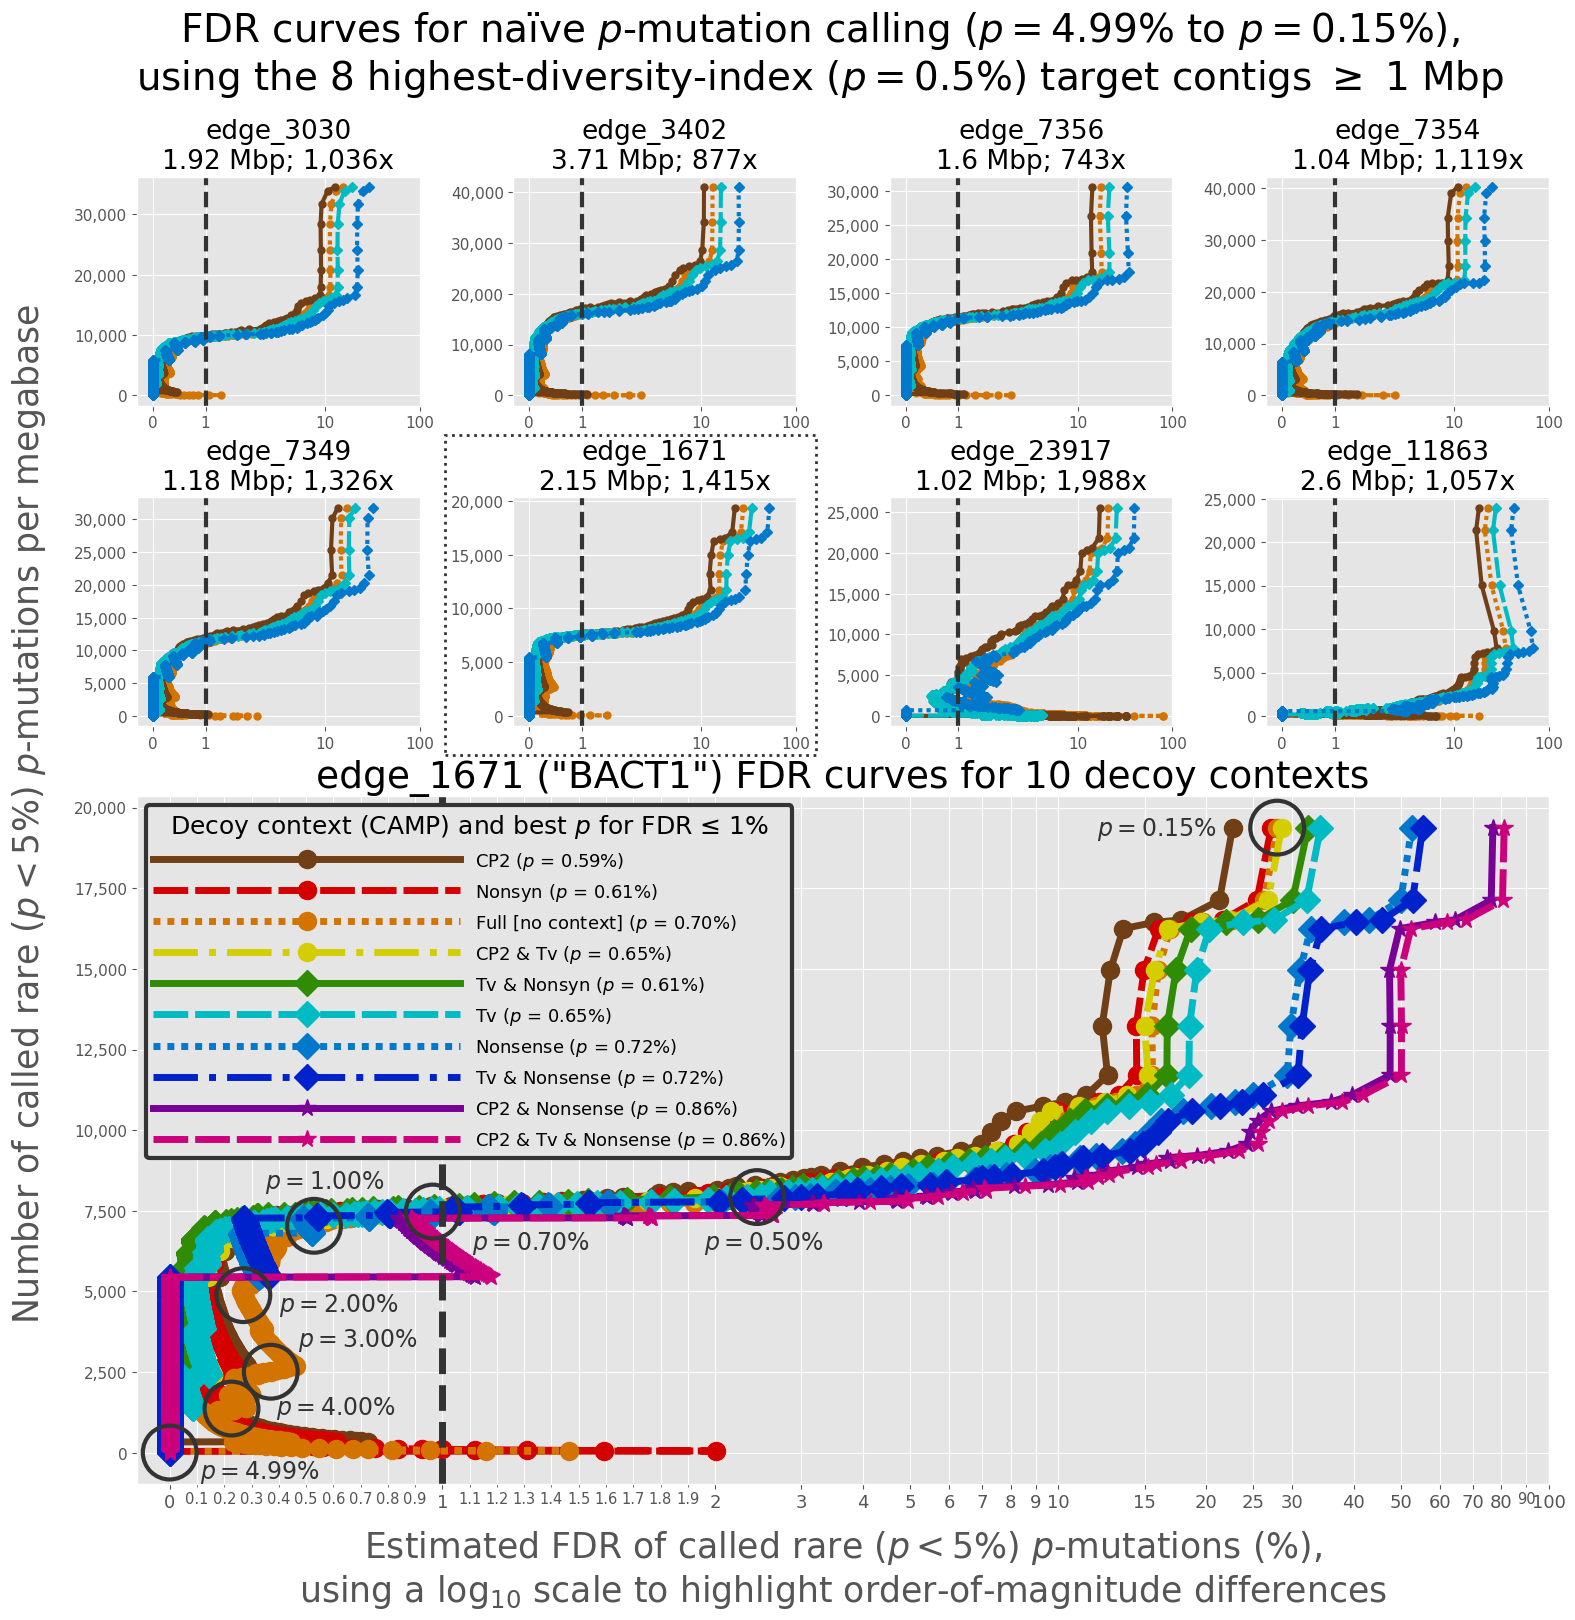

### 6.6. Fixing mutation calls' FDRs to an upper limit of $1\%$

FDR estimates are nice (they lend some context to our naïve mutation calls), but we can take things a step further. strainFlye has the ability to _fix_ the estimated FDR for each target contig's mutation calls to a specified upper limit.

Since we already have FDR curves showing how, as $p$ varies, the estimated FDR for each target contig varies, fixing the estimated FDR to an upper limit $F$ amounts to choosing (for each target contig) the "best" value of $p$ that yields a FDR ≤ $F$. The `strainFlye fdr fix` command takes care of this for us. (If you'd like more details on this process, see the methods section of the strainFlye paper, and/or [this unnecessarily fancy comment](https://github.com/fedarko/strainFlye/blob/2b01c92422c3a77831efb8d69a9463b288b2741f/strainflye/fdr_utils.py#L2364-L2421) in the strainFlye code.)

In [9]:
!strainFlye fdr fix

Usage: strainFlye fdr fix [OPTIONS]

  Fix contigs' mutation calls' estimated FDRs to an upper limit.

  This takes as input the estimated FDRs from "strainFlye fdr estimate" (if
  you used multiple decoy contexts, then you will need to choose which set of
  FDR estimates to use here) to guide us on how to fix the FDR for each
  contig. Note that mutations that passed the "high" p or r threshold
  specified for "strainFlye fdr estimate", and thus were not used for FDR
  estimation, will all be included in the output BCF file from this command;
  these mutations are considered "indisputable."

  We include indisputable mutations from the decoy contig and from all target
  contigs in our output BCF file. We will only consider including non-
  indisputable mutations from the target contigs: the decision of which non-
  indisputable mutations will be included is based on the lowest p or r
  parameter for a target contig that yields an estimated FDR ≤ the fixed FDR
  given here.

Options:
 

In [30]:
!strainFlye fdr fix \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/call-p15/naive-calls.bcf \
    --fdr-info /Poppy/mfedarko/sftests/tutorial-output/p15-fdr-info.tsv \
    --fdr 1 \
    --output-bcf /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf

--------
strainFlye fdr fix @ 0.00 sec: Starting...
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/call-p15/naive-calls.bcf
Input FDR estimate file: /Poppy/mfedarko/sftests/tutorial-output/p15-fdr-info.tsv
Input FDR to fix mutation calls at: 1.0
Verbose?: No
Output BCF file with mutation calls at the fixed FDR: /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf
--------
strainFlye fdr fix @ 0.00 sec: Loading and checking BCF and TSV files...
strainFlye fdr fix @ 14.93 sec: Looks good so far; decoy contig seems to be edge_6104.
strainFlye fdr fix @ 14.93 sec: Looks like the cutoff for "indisputable" mutations was p = 500.
strainFlye fdr fix @ 14.93 sec: All mutations passing this cutoff will be included in the output BCF file.
--------
strainFlye fdr fix @ 14.93 sec: Based on the FDR information, finding optimal values of p for each contig...
strainFlye fdr fix @ 14.95 sec: Done.
strainFlye fdr fix @ 14.95 sec: For 155 / 467 contigs, there exist values of p (at least, cons

It took us a few steps, but we have now generated a file (`p15-fdr1pct.bcf`) of $p$-mutation calls at a fixed (estimated) FDR of 1%.

Although our methodology has a few limitations (e.g. we don't support calling multi-allelic mutations yet), this BCF file can be used downstream for many types of analyses. In the next sections of the tutorial we'll demonstrate the additional commands supported by strainFlye, most of which make use of these mutation calls in some way.

## 7. Identify hotspots and coldspots

We've called mutations and estimated these calls' FDRs. Now we can get to the fun part: what's going on with these mutations?

Often, we're interested in analyzing mutations' locations in the contigs. Are there any particular "hotspot" regions where there are surprisingly many mutations? Are there any "coldspot" regions where there are, surprisingly, no or few mutations?

We've kept strainFlye's functionality for identifying these types of regions fairly minimal at the moment. Here we'll demonstrate identifying very basic hotspots and coldspots using `strainFlye spot`'s commands.

In [10]:
!strainFlye spot

Usage: strainFlye spot [OPTIONS] COMMAND [ARGS]...

  [+] Identify putative mutational hotspots or coldspots.

  Many methods exist for identifying these sorts of hotspots or coldspots;
  strainFlye's implementations of these methods are intended mostly as a quick
  proof-of-concept for replicating the results shown in our paper, and are not
  extremely "feature-rich" quite yet.

Options:
  -h, --help  Show this message and exit.

Commands:
  hot-features  Identify hotspot features (for example, genes).
  cold-gaps     Identify long coldspot "gaps" without any mutations.


### 7.1. Identify hotspot features

In [11]:
!strainFlye spot hot-features

Usage: strainFlye spot hot-features [OPTIONS]

  Identify hotspot features (for example, genes).

  By "feature", we refer to a single continuous region within a contig, as
  described in the file given for --features. These regions could describe
  anything: predicted protein-coding genes, introns or exons, intergenic
  regions of interest, etc. For now, we treat each feature independently (e.g.
  we don't lump together exons from the same "Parent" gene; each feature is
  considered separately as a potential "hotspot").

  You can configure whether or not we classify a feature as a hotspot by
  adjusting the --min-num-mutations and --min-perc-mutations parameters; at
  least one of these parameters must be specified. If both parameters are
  specified, then both checks (number of mutations in a feature, and
  percentage of mutations in a feature) will need to pass in order for us to
  label a feature as a hotspot.

Options:
  -b, --bcf PATH                  Indexed BCF file describing

#### 7.1.1. A note about "features"

Although we should be familiar with the FASTA and BCF input files by this point, the `-f` / `--features` input (a GFF3 file) may be surprising. strainFlye leaves the task of creating this file up to the user.

Predicted genes' coordinates are probably the most obvious type of "feature" for which we could look for hotspots. If you don't have gene predictions for your contigs yet, [Prodigal](https://github.com/hyattpd/Prodigal) is good (and should have been installed along with strainFlye, since it's used internally elsewhere in strainFlye). Here, we'll use it to predict protein-coding genes across all contigs.

It's important to note that Prodigal does not predict eukaryotic genes (i.e. genes that are split up into introns and exons). These genes will thus not be a perfect representation of all protein-coding genes in all contigs in the dataset, since we know that this sample does contain at least some eukaryotic genomes. (However, if you use another tool for predicting eukaryotic genes that produces GFF3 output, then these should also be usable as "features" for this command.)

In [ ]:
# See https://github.com/hyattpd/Prodigal/wiki/cheat-sheet for details about these options.
#
# Note that, for the paper, I ran Prodigal in "normal" mode on certain contigs individually
# (https://github.com/fedarko/sheepgut/blob/main/inspect-seqs/prodigal.py), but here we just
# run Prodigal in "anonymous" mode on all contigs at once. The results should be fairly similar,
# although there'll probably be some differences.
!prodigal \
    -i /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta \
    -f gff \
    -c \
    -p meta \
    -o /Poppy/mfedarko/sftests/tutorial-output/prodigal_anonymous.gff

#### 7.1.2. Running the command to identify hotspot features (hotspot predicted genes)

Now that we have our gene predictions, let's move see if any of them have a lot of mutations. (Based on our findings in the paper, we know that these sorts of hotspots do exist in this dataset.)

`strainFlye spot hot-features` supports two types of basic thresholds for labelling a feature as a hotspot, `--min-num-mutations` and `--min-perc-mutations`. We'll use both here, and label a feature a "hotspot" if it meets both of the following criteria:

1. it contains at least 5 mutations, and
2. at least 2% of its positions have mutations.

In [20]:
!strainFlye spot hot-features \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf \
    --features /Poppy/mfedarko/sftests/tutorial-output/prodigal_anonymous.gff \
    --min-num-mutations 5 \
    --min-perc-mutations 2 \
    --output-hotspots /Poppy/mfedarko/sftests/tutorial-output/hotspot-features-n5p2.tsv

Using strainFlye version "0.1.0-dev".
--------
spot hot-features @ 0.00s: Starting...
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf
Input feature file: /Poppy/mfedarko/sftests/tutorial-output/prodigal_anonymous.gff
Input minimum number of mutations needed to call a feature a hotspot: 5
Input minimum % of mutations needed to call a feature a hotspot: 2.0
Output file describing hotspot features: /Poppy/mfedarko/sftests/tutorial-output/hotspot-features-n5p2.tsv
--------
spot hot-features @ 0.00s: Loading and checking the BCF file...
spot hot-features @ 12.20s: Looks good so far.
--------
spot hot-features @ 12.20s: Going through features in the GFF3 file and identifying hotspot features...
spot hot-features @ 100.13s: Identified 57,188 hotspot feature(s) across all 468 contigs in the BCF file.
--------
spot hot-features @ 100.13s: Writing out this information to a TSV file...
spot hot-features @ 100.29s: Done.
--------
spot hot-features @ 100.30s: Done.


The output of this command isn't anything special: it's a TSV file in which each row describes an identified hotspot feature, defining "hotspots" based on the `--min-num-mutations` and `--min-perc-mutations` options we set earlier. Let's load this file using `pandas.read_csv()` and get a brief sense of what it looks like:

In [21]:
hotspots = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/hotspot-features-n5p2.tsv", sep="\t")
hotspots.head()

,Contig,FeatureID,FeatureStart_1IndexedInclusive,FeatureEnd_1IndexedInclusive,NumberMutatedPositions,PercentMutatedPositions
0,edge_8,8_765,865350,866369,32,3.14
1,edge_8,8_781,873414,873626,5,2.35
2,edge_8,8_787,878293,879429,48,4.22
3,edge_8,8_788,879444,881552,101,4.79
4,edge_8,8_789,881718,882956,42,3.39


Depending on your goals, we could focus on—for example—the hotspot genes with the highest mutation rates in a contig. We can compute this for `edge_1671` ("BACT1", as we name it in our paper) by filtering and then sorting the DataFrame:

In [23]:
bact1_hotspots = hotspots[hotspots["Contig"] == "edge_1671"]

# Sort all the "hotspot genes" in BACT1 from high to low mutation rates (% of positions mutated).
# This is similar to the table of highly-mutated genes in the Supplemental Material of our paper,
# although unlike that table this uses FDR-fixed mutations (and it also uses different gene
# predictions, as discussed above).
bact1_hotspots.sort_values(["PercentMutatedPositions"], ascending=False)

,Contig,FeatureID,FeatureStart_1IndexedInclusive,FeatureEnd_1IndexedInclusive,NumberMutatedPositions,PercentMutatedPositions
12437,edge_1671,1671_860,1041656,1042084,86,20.05
12473,edge_1671,1671_1217,1460034,1460204,34,19.88
12373,edge_1671,1671_183,206606,207304,131,18.74
12467,edge_1671,1671_1168,1402353,1402718,61,16.67
12456,edge_1671,1671_1102,1326288,1327073,120,15.27
...,...,...,...,...,...,...
12422,edge_1671,1671_751,916664,918493,37,2.02
12375,edge_1671,1671_248,272253,273047,16,2.01
12461,edge_1671,1671_1131,1361175,1361672,10,2.01
12421,edge_1671,1671_750,914486,916576,42,2.01


### 7.2. Identify coldspot gaps

Similarly, strainFlye supports the identification of basic "coldspots"—here, defined as long gaps without any mutations. The main parameter is the minimum length needed to define a gap as a "coldspot." Let's test this out on the SheepGut dataset:

In [12]:
!strainFlye spot cold-gaps

Usage: strainFlye spot cold-gaps [OPTIONS]

  Identify long coldspot "gaps" without any mutations.

  To clarify, we define a "gap" of length L on a contig as a collection of
  continuous positions [N, N + 1, ... N + L - 2, N + L - 1] in which no
  positions are mutations (based on the input BCF file).

  If the --circular flag is specified, then we can loop around the contig from
  right to left; otherwise, the left and right sides of the contig are hard
  boundaries. To give an example of this, consider a 9-nucleotide contig that
  has mutations at positions 4 and 6:

                             Mut.    Mut.
                  1   2   3   4   5   6   7   8   9

  If --circular is specified, then this contig has two gaps: one gap of length
  1 (covering just position 5, between the two mutations), and another gap of
  length 6 (starting at position 7 and looping around to position 3: [7, 8, 9,
  1, 2, 3]).

  If --circular is not specified, then this contig has three gaps: [1, 2, 3],


In [18]:
!strainFlye spot cold-gaps \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf \
    --output-coldspots /Poppy/mfedarko/sftests/tutorial-output/coldspot-gaps-minlen5000-nocircular.tsv

Using strainFlye version "0.1.0-dev".
--------
spot cold-gaps @ 0.00s: Starting...
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf
Minimum coldspot gap length: 5,000 bp
Check for circular coldspot gaps?: No
Compute exact longest-gap p-values?: Yes
Output file describing coldspot gaps: /Poppy/mfedarko/sftests/tutorial-output/coldspot-gaps-minlen5000-nocircular.tsv
--------
spot cold-gaps @ 0.00s: Loading and checking the BCF file...
spot cold-gaps @ 12.10s: Looks good so far.
--------
spot cold-gaps @ 12.10s: Going through contigs and identifying coldspot gaps...
spot cold-gaps @ 15.71s: Identified 15,258 coldspot gap(s) across all 468 contigs in the BCF file.
--------
spot cold-gaps @ 15.71s: Writing out this information to a TSV file...
spot cold-gaps @ 15.72s: Done.
--------
spot cold-gaps @ 15.72s: Done.


Again, `cold-gaps` will output a simple TSV file describing its identified coldspots:

In [19]:
coldspots = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/coldspot-gaps-minlen5000-nocircular.tsv", sep="\t")
coldspots.head()

,Contig,Start_1IndexedInclusive,End_1IndexedInclusive,Length,LongestGap_P_Value
0,edge_8,383672,681281,297610,NaN
1,edge_8,681283,715603,34321,NaN
2,edge_8,717621,865477,147857,NaN
3,edge_8,885778,906394,20617,NaN
4,edge_8,913216,920714,7499,NaN


There are many ways we could make use of this information—similarly to the hotspot example, we could try sorting these gaps from longest to shortest for the BACT1 contig. This is shown below. (Of the gaps that we identify, the longest one in each contig is assigned a _p_-value; please see the Supplemental Material of our paper for details on how we compute this, and the assumptions made.)

In [20]:
coldspots[coldspots["Contig"] == "edge_1671"].sort_values(["Length"], ascending=False)

,Contig,Start_1IndexedInclusive,End_1IndexedInclusive,Length,LongestGap_P_Value
2387,edge_1671,1216892,1239536,22645,1.168921e-103
2388,edge_1671,1618448,1637614,19167,NaN
2389,edge_1671,1797824,1813581,15758,NaN
2385,edge_1671,1194740,1207381,12642,NaN
2390,edge_1671,2140896,2153394,12499,NaN
2383,edge_1671,979572,990495,10924,NaN
2380,edge_1671,740701,750399,9699,NaN
2386,edge_1671,1207881,1216890,9010,NaN
2384,edge_1671,1183003,1191716,8714,NaN
2382,edge_1671,972772,979570,6799,NaN


## 8. Phasing analyses

### 8.1. Generating "smoothed haplotypes"

Given our called mutations, we can attempt to generate haplotypes that respect these mutations using strainFlye's `smooth` module.

The details and motivation for this are explained in depth in our paper. To briefly summarize, we will convert the reads aligned to each contig into "smoothed reads," which only contain our called mutations with no other variations. We will then (optionally, depending on the `--virtual-reads` parameter) construct "virtual reads" to fill in low-coverage regions. We will then assemble these reads using [LJA](https://github.com/AntonBankevich/LJA/) to construct "smoothed haplotypes."

Note that these commands (both `smooth create` and `smooth assemble`) can take a while to run. You can add the `--verbose` flag to get more detailed logging information while these commands are running.

In [13]:
!strainFlye smooth

Usage: strainFlye smooth [OPTIONS] COMMAND [ARGS]...

  [+] Create and assemble smoothed and virtual reads.

Options:
  -h, --help  Show this message and exit.

Commands:
  create    Create smoothed and virtual reads for each contig.
  assemble  Assemble contigs' smoothed and virtual reads using LJA.


#### 8.1.1. Creating smoothed and virtual reads

In [14]:
!strainFlye smooth create

Usage: strainFlye smooth create [OPTIONS]

  Create smoothed and virtual reads for each contig.

Options:
  -c, --contigs PATH              FASTA file of contigs for which we will
                                  create smoothed and virtual reads. All
                                  contigs in this FASTA file should also be
                                  contained in the BAM and BCF files; it's ok
                                  if the BAM or BCF files contain contigs not
                                  in this FASTA file (we'll ignore them).
                                  [required]
  --bam PATH                      Sorted and indexed BAM file representing an
                                  alignment of reads to contigs.  [required]
  --bcf PATH                      Indexed BCF file describing single-
                                  nucleotide mutations in a set of contigs.
                                  [required]
  -di, --diversity-indices PATH   TSV file describ

In [ ]:
!strainFlye smooth create \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta \
    --bam /Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf \
    --diversity-indices /Poppy/mfedarko/sftests/tutorial-output/call-p15/diversity-indices.tsv \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/smooth/reads

#### 8.1.2. Assembling these reads

This step assumes that we have already installed [LJA](https://github.com/AntonBankevich/LJA/), in particular the `simple_ec` branch of it. Please see [LJA's manual](https://github.com/AntonBankevich/LJA/blob/main/docs/lja_manual.md) for installation instructions.

I have installed LJA into a specific location on our cluster. So that strainFlye can easily run LJA for each contig's reads files, we pass the location of LJA's binary executable to strainFlye below using the `--lja-bin` parameter.

In [15]:
!strainFlye smooth assemble

Usage: strainFlye smooth assemble [OPTIONS]

  Assemble contigs' smoothed and virtual reads using LJA.

  Please note that this command relies on the "simple_ec" branch of LJA being
  installed on your system. See strainFlye's README (and/or LJA's manual) for
  details on installing LJA.

Options:
  -r, --reads-dir DIRECTORY   Directory produced by "strainFlye smooth create"
                              containing smoothed (and optionally virtual)
                              reads. We will use LJA to assemble each
                              *.fasta.gz file in this directory (representing
                              reads from different contigs) independently.
                              [required]
  -p, --lja-params TEXT       Additional parameters to pass to LJA, besides
                              the --reads and --output-dir parameters. To
                              explain our defaults: the --simpleec flag is
                              currently only available on 

In [ ]:
!strainFlye smooth assemble \
    --reads-dir /Poppy/mfedarko/sftests/tutorial-output/smooth/reads \
    --lja-bin /home/mfedarko/software/LJA-branch/bin/lja \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/smooth/assemblies

Once you've created these assemblies, you can then analyze them like you would any other assembly of a MAG. You may want to visualize the assembly graphs, for example—[Bandage](https://github.com/rrwick/Bandage), [AGB](https://github.com/almiheenko/AGB/), and [MetagenomeScope](https://github.com/marbl/MetagenomeScope) are a few tools that can do this.

For information about LJA-specific details of the outputs (e.g. what files mean what), please see [LJA's manual](https://github.com/AntonBankevich/LJA/blob/main/docs/lja_manual.md#output-of-la-jolla-assembler).

### 8.2. Constructing link graphs

As a related analysis, we can construct _link graphs_ showing "how much" of a contig we can potentially phase. These graphs are described in detail in the Supplemental Material of our paper.

Long story short, creating link graphs in strainFlye has two steps (like performing smoothed-read assembly above). First, we'll compute nucleotide (co-)occurrence data for each contig; then, we'll convert this data into link graphs.

In [17]:
!strainFlye link

Usage: strainFlye link [OPTIONS] COMMAND [ARGS]...

  [+] Create link graphs showing co-occurring alleles.

  The "nt" command should be run first; this generates information about the
  counts and co-occurrences of nucleotides at mutated positions in a contig.

  The "graph" command takes as input the information produced by "nt" and
  creates link graphs (one link graph per contig) from it. There are many
  parameters that impact the graph creation, so we have split this into two
  steps in order to make it easy to rerun the "graph" step with different
  parameter settings if needed (the "nt" command will likely take longer to
  run).

Options:
  -h, --help  Show this message and exit.

Commands:
  nt     Compute (co-)occurrence information for mutations' nucleotides.
  graph  Convert (co-)occurrence information into a link graph structure.


#### 8.2.1. Computing nucleotide (co-)occurrence information

This command will take a while (as shown below, it took ~47.84 hours to run on our cluster, or just under two days). As with other long-running commands in the pipeline, using `--verbose` may be helpful if you'd like to see intermediate logging messages.

##### A brief note about filtering
Note that, in the paper's Supplemental Material, we limited our focus to mutated positions with coverages of at least 1,000x. We do not do this here. If you'd like to perform this same sort of filtering—and only consider mutations occurring at positions with at least a certain minimum coverage—you'll need to filter the BCF file yourself. (You could probably use [bcftools](https://samtools.github.io/bcftools/howtos/filtering.html) to do this; if you are using a BCF file produced by strainFlye, then you can filter based on the `MDP` info tag, which describes the number of matching + mismatching reads at a mutated position.)

In [19]:
!strainFlye link nt

Usage: strainFlye link nt [OPTIONS]

  Compute (co-)occurrence information for mutations' nucleotides.

Options:
  -c, --contigs PATH          FASTA file of contigs for which we will create
                              link graphs. All contigs in this FASTA file
                              should also be contained in the BAM and BCF
                              files; it's ok if the BAM or BCF files contain
                              contigs not in this FASTA file (we'll ignore
                              them).  [required]
  --bam PATH                  Sorted and indexed BAM file representing an
                              alignment of reads to contigs.  [required]
  --bcf PATH                  Indexed BCF file describing single-nucleotide
                              mutations in a set of contigs.  [required]
  -o, --output-dir DIRECTORY  Directory to which information about nucleotide
                              frequencies at the mutated positions in each
            

In [32]:
!strainFlye link nt \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta \
    --bam /Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/link/nt

Using strainFlye version "0.1.0-dev".
--------
link nt @ 0.00s: Starting...
Input contig file: /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta
Input BAM file: /Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/p15-fdr1pct.bcf
Verbose?: No
Output directory: /Poppy/mfedarko/sftests/tutorial-output/link/nt
--------
link nt @ 0.00s: Loading and checking FASTA, BAM, and BCF files...
link nt @ 4.56s: The FASTA file describes 468 contig(s).
link nt @ 4.64s: All FASTA contig(s) are included in the BAM file (this BAM file has 78,793 reference(s)).
link nt @ 15.89s: All FASTA contig(s) are included in the BCF file (the header of this BCF file describes 468 contig(s)).
link nt @ 15.90s: The lengths of all contig(s) in the FASTA file match the corresponding lengths in the BAM and BCF files.
link nt @ 15.90s: So far, these files seem good.
--------
link nt @ 15.90s: Going through contigs

#### 8.2.2. Converting this information to create link graphs

This next command directly takes as input the information we just computed. You can experiment with various parameters of graph construction here, if you'd like; the defaults match what we have set in the paper. (The help text for this command, shown below, explains these parameters in detail.)

In [ ]:
!strainFlye link graph

In [ ]:
!strainFlye link graph \
    --nt-dir /Poppy/mfedarko/sftests/tutorial-output/link/nt \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/link/graph \

#### 8.2.3. Visualizing CAMP's link graph

[//]: # "re: %28 and %29, we need to escape the () to avoid messing up markdown: see https://meta.stackexchange.com/a/284559. also this is how you write comments in jupyter notebooks! see https://stackoverflow.com/a/59646511. isn't that wacky? hopefully you can't see this (if you can see this please lmk so i can fix this lol)"

Since we kept `-f`/`--output-format` set to the default of `dot`, the above command just created [DOT](https://en.wikipedia.org/wiki/DOT_%28graph_description_language%29) files for each contig's link graphs. These files can be easily visualized using [Graphviz](http://www.graphviz.org). (Graphviz is installed by default on many Linux systems; see its website for installation instructions. I've found that installing it from conda-forge seems to work well.)

Let's visualize the link graph for CAMP (`edge_6104`) as a simple example of how we might visualize link graphs in practice. It shouldn't contain too many mutations, so it's a simple starting point.

To visualize this graph we'll use Graphviz' [`sfdp` layout algorithm](http://yifanhu.net/PUB/graph_draw.pdf), which is useful for visualizing large undirected graphs.

In [ ]:
# make sure sfdp (and Graphviz) are installed
!which sfdp

In [ ]:
!sfdp \
    /Poppy/mfedarko/sftests/tutorial-output/link/graph/edge_6104_linkgraph.gv -Tpng \
    > edge_6104_linkgraph.png

<!-- the ? prevents my browser from trying to cache this file... see https://stackoverflow.com/a/43640705 -->
![CAMP's link graph](edge_6104_linkgraph.png?2)

And there we have it!

#### 8.2.4. Interpreting link graphs

What's going on in this graph? We see two large "groups" of alleles with high-link-weight edges. Each allele is labelled with four pieces of information:

1. Position on the contig (1-indexed)
2. Nucleotide (one of A, C, G, T)
3. Count
4. Frequency

Notice how the frequencies of alleles in the left group are mostly ~16%, and how the frequencies of alleles in the right group are mostly ~84%. These groups correspond to the two main "haplotypes" of gene 1217 in CAMP (ranging from left = 1,208,927 bp to right = 1,210,075 bp). We know from our paper (see Figure 5, as well as Supplemental Material "Haplotypes of the most mutated gene in CAMP") that the mutations in gene 1217 of CAMP have one ~84% haplotype and one ~16% haplotype: we see this pattern recapitulated clearly here.

There's also one mutation with a similar frequency distribution at position 766,857 bp, although this mutation isn't close enough to gene 1217's mutations to connect it.

Notice how there are a few low-count, low-frequency alleles on the periphery of this link graph (e.g. node 1,209,001 (T), with a count of 3x). These alleles pop up because, when we create nodes corresponding to alleles at mutated positions in a contig, we create these nodes for _all_ alleles at these mutated positions (with a count of at least the `--min-nt-count` parameter of `strainFlye link graph`)—not just those corresponding to the most common or second most common alleles at a mutated position. You can increase the `--min-nt-count` parameter to a higher number (e.g. 10) if you'd like to remove these low-count allele nodes.

##### Comparing this link graph with Figure S19 (bottom) in our paper

We note that this graph is a bit different from Figure S19 (bottom) in our paper, which also shows a link graph for CAMP. Why is this the case? Here are a few reasons:

- Figure S19's link graphs were created using simple $p = 0.5\%$ mutations (filtered to positions with a minimum coverage of 1,000x), whereas our link graphs were created from post-FDR-fixing mutations without any coverage filtering (and since we used CAMP as our decoy, we only include "indisputable" mutations in CAMP—i.e. those with frequency $p ≥ 5\%$).


- Figure S19 (bottom) only shows the largest component of CAMP—whereas this link graph shows the entirety of CAMP's link graph (but since we consider a likely smaller set of mutations, the link graph is not much larger).


- In Figure S19, I colored each node (allele) in the link graph based on the gene(s) in which it was located. ([This analysis notebook](https://nbviewer.org/github/fedarko/sheepgut/blob/main/notebooks/Phasing-02-VizGraph.ipynb) contains the code I used to do this.) Here we just visualize these DOT files as strainFlye outputs them, without any gene-coloring information; you can adjust nodes' colors yourself if desired, although for large graphs this will probably require some programming.

##### Other notes about link graphs

- When visualizing massive link graphs (e.g. for BACT1's largest component, as shown in Figure S19 (top) in our paper), you can adjust the [`dpi` attribute of the graph](https://graphviz.org/docs/attrs/dpi/) (for BACT1's largest component, I added `dpi=20;` to the top of its DOT file) to reduce the visualization's filesize. You can also try removing the `label` attribute of nodes, since for massive graphs at low resolution these labels will be hard to read anyway.

## 9. Codon / amino acid mutation matrices

We don't discuss this much in the main text of the strainFlye paper, but it's possible to create mutation matrices showing how codons mutate into each other, specific to an individual contig. We can also derive amino acid mutation matrices from these. These matrices can in theory be useful as an alternative to more general amino acid mutation matrices like [PAM](https://en.wikipedia.org/wiki/Point_accepted_mutation) (Dayhoff _et al._, 1978) or [BLOSUM](https://en.wikipedia.org/wiki/BLOSUM) (Henikoff & Henikoff, 1992).

In our paper's Supplemental Material, we show off a few of these matrices for three MAGs. strainFlye supports creating these matrices for arbitrary contigs, and here we demonstrate how we can easily do this!

In [96]:
!strainFlye matrix

Usage: strainFlye matrix [OPTIONS] COMMAND [ARGS]...

  [+] Create codon and amino acid mutation matrices.

Options:
  -h, --help  Show this message and exit.

Commands:
  count  Count 3-mers aligned to contigs' codons.
  fill   Call codon mutations from 3-mer counts and fill in matrices.


Similarly to `strainFlye link`, the `strainFlye matrix` module is also split up into two steps (`count` and `fill`). The rationale behind this is that `count` takes a while and doesn't require many parameters, whereas `fill` goes by much quicker and has many adjustable parameters. So it's convenient to have a "break" in the process this way.

### 9.1. Counting 3-mers aligned to codons

We'll reuse `prodigal_anonymous.gff`, the file of protein-coding gene predictions that we generated above using Prodigal. This tells strainFlye where each contig's genes are, and from there we can figure out where its codons are (and what reads are aligned to each of these codons).

This will take a while, so you may want to use `--verbose` and/or filter your FASTA file (e.g. if you only want to draw a mutation matrix for a single contig, filtering your FASTA file to this one contig should speed things up a lot).

In [97]:
!strainFlye matrix count

Usage: strainFlye matrix count [OPTIONS]

  Count 3-mers aligned to contigs' codons.

Options:
  -c, --contigs PATH          FASTA file of contigs in which we'll count
                              3-mers aligned to codons in predicted genes. All
                              contigs in this FASTA file should also be
                              contained in the BAM file; it's ok if the BAM
                              file contains contigs not in this FASTA file
                              (we'll ignore them). We'll also ignore contigs
                              for which no gene coordinates are given.
                              [required]
  -b, --bam PATH              Sorted and indexed BAM file representing an
                              alignment of reads to contigs.  [required]
  -g, --genes PATH            Generic Feature Format version 3 (GFF3) file
                              describing gene coordinates within contigs.
                              We'll only cons

In [ ]:
!strainFlye matrix count \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta \
    --bam /Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam \
    --genes /Poppy/mfedarko/sftests/tutorial-output/prodigal_anonymous.gff \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/matrix/count

Using strainFlye version "0.1.0-dev".
--------
matrix count @ 0.00s: Starting...
Input contig file: /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta
Input BAM file: /Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam
Input GFF3 file: /Poppy/mfedarko/sftests/tutorial-output/prodigal_anonymous.gff
Verbose?: No
Output directory: /Poppy/mfedarko/sftests/tutorial-output/matrix/count
--------
matrix count @ 0.00s: Loading and checking FASTA and BAM files...
matrix count @ 5.26s: The FASTA file describes 468 contig(s).
matrix count @ 5.26s: All of these are included in the BAM file (which has 78,793 reference(s)), with the same lengths.
--------
matrix count @ 5.26s: Counting aligned 3-mers to codons in coding sequences in contigs...


### 9.2. Calling codon mutations from aligned 3-mer counts, creating mutation matrices

The long part is over! Now that we have counts of which 3-mers were aligned to the codons in the coding sequences of our contigs, we can call codon mutations.

Calling codon mutations is done similarly, in our pipeline, to how we call single-nucleotide mutations. We support either $p$ or $r$ codon mutation calling (using frequencies or read counts). Here we'll do $p$-mutation calling at $p = 0.5\%$, just to be consistent with the paper's Supplemental Material.

##### Minor sidenote: skipping this step and calling codon mutations manually

If you'd prefer, you could in theory call codon mutations from these counts through a more sophisticated method—this is one of those advantages of splitting up `count` and `fill` into two separate commands. (However: in order to do this, you'd need to load the 3-mer count data yourself—it's stored as a [pickled](https://docs.python.org/3/library/pickle.html) representation of a `CodonCounter` object, which is defined in strainFlye's source code [here](https://github.com/fedarko/strainFlye/blob/692a57f0525025d54cf00e4e3629f18bf722bb2a/strainflye/matrix_utils.py#L20). Feel free to open an issue on GitHub if you have questions about interacting with this object.)

In [102]:
!strainFlye matrix fill

Usage: strainFlye matrix fill [OPTIONS]

  Call codon mutations from 3-mer counts and fill in matrices.

  You can call either p-mutations (based on codon frequencies) or r-mutations
  (based just on codon counts) using -p or -r. These methods work analogously
  to how they are described in "strainFlye call", with the addition that we do
  not call codon mutations for "unreasonable" codons where the most common
  aligned 3-mer (or, in the case of a tie, any of the most common aligned
  3-mers) at this codon is not exactly the same as the "reference" codon's
  3-mer.

  It's worth noting that the amino acid mutation matrix is derived directly
  from the codon mutation matrix: that is, as soon as we identify a mutation
  from one codon (C1) into another codon (C2), we also record a mutation in
  the amino acid matrix from translate(C1) into translate(C2). We could
  arguably do this in a different way (count the translations of each 3-mer
  aligned to a codon, then call amino acid mutati

In [ ]:
!strainFlye matrix fill \
    --count-dir /Poppy/mfedarko/sftests/tutorial-output/matrix/count \
    -p 50 \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/matrix/final

### 9.3. Visualizing mutation matrices

First, let's load and inspect a codon mutation matrix. An entry (`row`, `col`) in the matrix gives the number of times codon `row` mutates into codon `col`: for example, for this matrix, we saw `AAA` mutate into `AAC` exactly 9 times. (**TODO: Redo this subsection with BACT1's matrix.**)

It is worth thinking about if you want to normalize the matrix in some way. For example, you may want to divide each entry in each row by the total number of mutations in this row (dividing each entry in `AAA`'s row by the total number of mutations from `AAA` into another codon, etc.). We don't do this here for the sake of simplicity, but it shouldn't be too much trouble to do this using pandas.

In [ ]:
cmat = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/matrix/final/edge_1671/edge_1671_codon_matrix.tsv", sep="\t")
cmat

The following code is a simplified version of how we visualized these matrices in the paper; [the original notebook for visualizing these matrices is here](https://nbviewer.org/github/fedarko/sheepgut/blob/main/notebooks/Matrices-02-Viz.ipynb).

In [ ]:
# Get the tab20 color map. This returns an object that we can call with, e.g. (0) to get the first
# color, (1) to get the second color, etc. See https://stackoverflow.com/a/25408562.
# (List of matplotlib color maps: https://matplotlib.org/stable/gallery/color/colormap_reference.html)
cmap = matplotlib.cm.get_cmap("tab20")
colors = [cmap(i) for i in range(20)]
hexcolors = [matplotlib.colors.to_hex(c) for c in colors]

# Map the 20 amino acids to a unique tab20 color, and then keep the stop codon (item 21)'s text color as black
# so that it has a unique color.
aa2color = {}
aas = "ACDEFGHIKLMNPQRSTVWY*"
for i, aa in enumerate(aas[:-1]):
    aa2color[aa] = hexcolors[i]
aa2color["*"] = "#000000"

In [ ]:
fig, ax = pyplot.subplots()
ax.imshow(cmat.values)
ax.grid(False)
ax.tick_params(
    top=True, bottom=True, left=True, right=True,
    labeltop=True, labelbottom=True, labelleft=True, labelright=True
)
toplabels = []
leftlabels = []
for oi, o in enumerate(cmat.index):
    t = skbio.DNA(o).translate()
    # Assign each codon a color based on its translation
    toplabels.append(f"{t}\n{o}")
    leftlabels.append(f"{t} {o}")
    
# As in "tick i's". This specifies where to put all the ticks. (If we omit this,
# then only a few of the tick labels are shown.)
tick_is = range(len(cmat.index))
ax.set_xticks(tick_is)
ax.set_yticks(tick_is)
    
ax.set_xticklabels(toplabels)
ax.set_yticklabels(leftlabels)

def set_text_style(ticklabel, fontsize="xx-large"):
    # Figure out the color for this tick based on its amino acid / stop codon
    tl.set_color(aa2color[tl.get_text().split()[0]])
    tl.set_fontweight("bold")
    tl.set_fontfamily("monospace")
    tl.set_fontsize(fontsize)
    
for tl in ax.get_yticklabels():
    set_text_style(tl)
for tl in ax.get_xticklabels():
    set_text_style(tl, fontsize="large")
    
ax.set_ylabel("Mutated from", fontsize=30)
ax.set_xlabel("Mutated into", fontsize=30)
ax.set_title('Codon mutation matrix ($p = 0.5\%$) for edge_1671 ("BACT1")', fontsize=40, y=1.03)
fig.set_size_inches(27, 27)

So that's an example of how we can visualize mutation matrices! Making them look pretty takes a bit of work, but matplotlib helps a lot. There are lots of other ways to improve these visualizations—e.g. showing the exact number of mutations in each cell of the matrix, showing the "reference counts" on the diagonal of the codon matrix, etc. [The notebook I used to visualize matrices for the paper](https://github.com/fedarko/sheepgut/blob/main/notebooks/Matrices-02-Viz.ipynb) goes much more in-depth, although it's a bit of a rat's nest.

Of course, mutation matrices have other uses besides visualization—as mentioned, they could in theory be useful as a way to compare alignments of genes or proteins, similarly to the PAM or BLOSUM matrices. strainFlye just focuses on computing these matrices, so whatever you do with them is up to you :)

## 10. Growth dynamics analyses

One of the nice things of having complete or nearly-complete MAGs is that we can take a look at both their GC skews and coverages.

GC skews can sometimes be indicative of where the origin and terminus of replication are in a genome (this is discussed extensively in [Chapter 1 of the _Bioinformatics Algorithms_ textbook](https://www.bioinformaticsalgorithms.org/bioinformatics-chapter-1)). Similarly, we know from ([Korem, Zeevi, Suez _et al._, 2015](https://www.science.org/doi/full/10.1126/science.aac4812)) that the coverage throughout a MAG can also be indicative of the origin of replication.

In our paper, we demonstrate the easy applicability of HiFi reads to this sort of analysis by showing plots of coverage vs. skew for three MAGs in the SheepGut dataset, demonstrating that—as we might expect—these values are anti-correlated. (Why are they _anti-correlated_, specifically? The skew minimum indicates the origin of replication, and coverage for a genome undergoing replication should be at its maximum near the origin of replication.)

The `strainFlye dynam covskew` command can help us ~~replicate~~ reproduce this sort of analysis. Rather than plotting coverage and skew for each position within a MAG, we usually want to create "bins" of positions within a MAG and then plot coverage and skew for these bins: strainFlye can give us this sort of information for a contig in an easy-to-read TSV file that we can use as input for plotting coverage and skew.

This command will take some time to run, so you may want to use `--verbose`.

### 10.1. Compute coverage/skew information

In [22]:
!strainFlye dynam covskew

Usage: strainFlye dynam covskew [OPTIONS]

  Compare coverage and GC skew within contigs.

  Bins
  ----
  We split each contig into bin(s) of a fixed number of positions:
  starting at the leftmost end of the contig, we combine the next
  --bin-length positions into a single bin, continuing until we run out of
  positions. The rightmost bin will contain fewer positions than --bin-length
  if the contig length is not divisible by --bin-length. (If the contig's
  length is ≤ --bin-length, we'll just create one bin for this contig.)

  Normalized coverages
  --------------------
  For each bin, we compute the median coverage of all positions in this bin.
  We then compute M, the median of these medians (considering all bins in a
  contig). We compute "normalized" coverages by dividing each bin's median
  coverage by M, and then clamping these normalized coverages to the range
  [1 - ϵ, 1 + ϵ]. (If M = 0, then we cannot do this normalization:
  in this case, we define each bin's normalize

In [ ]:
!strainFlye dynam covskew \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs_atleast_1Mbp.fasta \
    --bam /Poppy/mfedarko/sheepgut/main-workflow/output/fully-filtered-and-sorted-aln.bam \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/covskew \
    --verbose

### 10.2. Visualize coverage and skew

So we've got this information, but what can we do with it? The most obvious answer is that we can plot it without too much effort. Visually, this will let us see if (normalized) coverage and skew are anti-correlated. (You could also imagine performing some sort of correlation analysis / regression between these quantities, but let's keep it simple for now.)

Here, we'll replicate part of Figure S17 in our paper (the exact code that generated that figure is [in this notebook](https://nbviewer.org/github/fedarko/sheepgut/blob/main/notebooks/CoverageSkewPlots.ipynb)). For the sake of simplicity, we'll just do this for a single contig: CAMP, or `edge_6104`.

In [86]:
# Load the coverage / skew TSV file, and see what the first few lines in it look like
covskew = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/covskew/edge_6104_covskew.tsv", sep="\t")
covskew.head()

,LeftPos_1IndexedInclusive,CenterPos,NormalizedCoverage,CumulativeSkew
0,1,5000.5,1.182814,0.013732
1,10001,15000.5,1.164070,0.107924
2,20001,25000.5,1.180136,0.143035
3,30001,35000.5,1.155794,0.265320
4,40001,45000.5,1.169426,0.506219


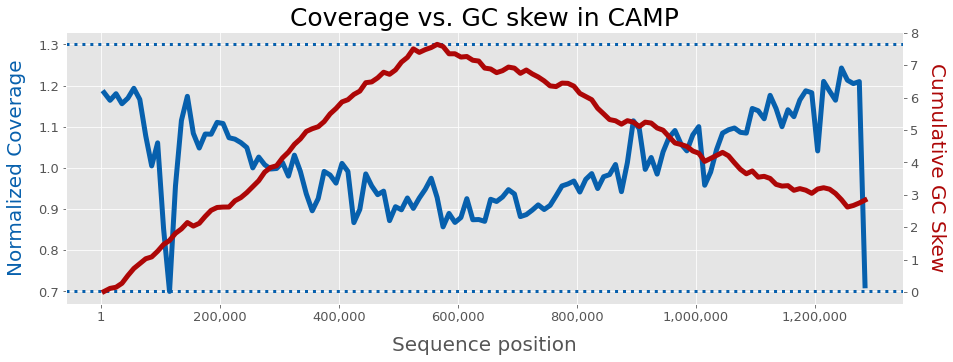

In [95]:
cov_color = "#0760ad"
skew_color = "#ad0707"

fig, ax = pyplot.subplots()

# twinx() lets us plot coverage and skew on the same plot.
ax_skew = ax.twinx()
ax.plot(covskew["CenterPos"], covskew["NormalizedCoverage"], color=cov_color, lw=5)
ax_skew.plot(covskew["CenterPos"], covskew["CumulativeSkew"], color=skew_color, lw=5)
# turn off skew gridlines, which get in the way visually.
ax_skew.grid(False)
# plot the low and upper normalized coverage bounds, for reference
for ybound in [0.7, 1.3]:
    ax.axhline(y=ybound, linestyle=":", color=cov_color, lw=3)

ax.set_xlabel("Sequence position", labelpad=12, fontsize=20)
ax.set_ylabel("Normalized Coverage", labelpad=12, fontsize=20, color=cov_color)
ax_skew.set_ylabel("Cumulative GC Skew", labelpad=28, fontsize=20, color=skew_color, rotation=-90)
ax.set_title("Coverage vs. GC skew in CAMP", fontsize=25)
ax.xaxis.set_major_formatter("{x:,.0f}")
ax.set_xticks([1, 2e5, 4e5, 6e5, 8e5, 10e5, 12e5])
ax.tick_params(axis="both", labelsize=13)
ax_skew.tick_params(axis="both", labelsize=13)

fig.set_size_inches(15, 5)

Nice—we've recreated the top plot in Figure S17 without needing to actually go through the alignment ourselves. We can just run `strainFlye dynam covskew` and then visualize the TSV it produces.

This plot makes it clear that coverage and skew are generally anti-correlated for CAMP, which provides some evidence that this particular MAG might be undergoing replication. If desired, we could compute the _peak-to-trough ratio (PTR)_ ([Korem, Zeevi, Suez _et al._, 2015](https://www.science.org/doi/full/10.1126/science.aac4812)) for CAMP to try to gain information about this MAG's replication rate; I'll leave this as an exercise for the reader :)

(...If you do compute the PTR, it's worth being careful about normalized coverage clamping causing problems with this computation—you may want to set `-e`/`--norm-coverage-epsilon` to something large, because if it's too small then the normalized coverages will get clamped, which will impact your computed PTRs.)